In [8]:
#!/usr/bin/env python3
"""
HRP Portfolio Optimizer
Author: John P.
Date: 12/13/2024
"""

# Standard library imports
import sys
import warnings

from pathlib import Path

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
sys.path.append(str(project_root))

# Third-party imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf

# Local imports
from src.proc.data_handler import DataHandler
from src.hrp.optimizer import HRPPortfolio
from src.viz.plots import plot_portfolio_analysis
from src.metrics.portfolio import PortfolioMetrics
from src.viz.plot_metrics import (
    plot_performance_metrics, 
    plot_risk_metrics, 
    plot_factor_analysis
)


In [9]:
# Environment Information
print(f"Python version: {sys.version}")
print("\nKey package versions:")
for package in ['numpy', 'pandas', 'matplotlib', 'yfinance']:
    print(f"{package}: {__import__(package).__version__}")

Python version: 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]

Key package versions:
numpy: 1.23.5
pandas: 1.5.3
matplotlib: 3.7.1
yfinance: 0.2.36


In [10]:
class PortfolioManager:
    def __init__(self, risk_free_rate: float = 0.02):
        self.data_handler = DataHandler()
        self.portfolio = HRPPortfolio()
        self.risk_free_rate = risk_free_rate
        
    def run_portfolio_optimization(
        self,
        data_path: str,
        min_market_cap: int,
        start_date: str,
        end_date: str,
        num_clusters: int = 3,
        risk_measure: str = "variance",
        n_stocks: int = 50
    ):
        # Load and process data
        df = self.data_handler.load_market_data(data_path, min_market_cap)
        df = self.data_handler.calculate_quality_metrics(df)
        df = self.data_handler.calculate_financial_strength(df)
        df = self.data_handler.calculate_value_metrics(df)
        df = self.data_handler.calculate_composite_score(df)
        
        top_n = df.head(n_stocks)
        hrp_df = pd.DataFrame({
            'ticker': top_n['Full Ticker'].str.split(':').str[1],
            'market_cap': top_n['market_cap']
        })
        
        # Optimize portfolio
        portfolio_metrics = self.portfolio.optimize_portfolio(
            tickers=hrp_df['ticker'].tolist(),
            market_caps=hrp_df['market_cap'].values,
            start_date=start_date,
            end_date=end_date,
            num_clusters=num_clusters,
            risk_measure=risk_measure,
            max_weight=.05
        )
        
        # Calculate portfolio analytics
        metrics = PortfolioMetrics(
            returns=portfolio_metrics.returns,
            weights=portfolio_metrics.weights,
            risk_free_rate=self.risk_free_rate
        )
        analytics = metrics.calculate_all_metrics()
        
        # Download factor data and calculate factor analysis
        factor_tickers = ['SPY', 'IWM', 'VTV']  # Market, Size, Value factors
        factor_data = yf.download(factor_tickers, start=start_date, end=end_date)['Adj Close']
        factor_returns = factor_data.pct_change().dropna()
        factor_returns.columns = ['Market', 'Size', 'Value']
        
        factor_betas, factor_contribution = metrics.perform_factor_analysis(factor_returns)
        risk_contribution = metrics.calculate_risk_contribution()
        
        # Generate results DataFrame
        results = pd.DataFrame({
            'Weight': portfolio_metrics.weights,
            'Cluster': portfolio_metrics.clusters,
            'Risk_Contribution': risk_contribution
        })
        results['Market_Cap'] = hrp_df.set_index('ticker')['market_cap']
        
        # Create visualizations
        # Portfolio composition plot
        fig1 = plot_portfolio_analysis(
            portfolio_metrics.returns,
            portfolio_metrics.weights,
            portfolio_metrics.linkage_matrix
        )
        plt.show()
        
        # Performance metrics
        fig2 = plot_performance_metrics(analytics)
        plt.show()
        
        # Risk metrics
        fig3 = plot_risk_metrics(analytics)
        plt.show()
        
        # Factor analysis and additional metrics
        fig4 = plot_factor_analysis(factor_betas, risk_contribution, analytics)
        plt.show()
        
        # Print summary metrics and factor analysis
        print("\nPortfolio Risk Metrics:")
        for metric, value in analytics.risk_metrics.items():
            print(f"{metric}: {value:.4f}")
            
        print("\nRisk-Adjusted Metrics:")
        for metric, value in analytics.risk_adjusted_metrics.items():
            print(f"{metric}: {value:.4f}")
            
        print("\nFactor Exposures:")
        for factor, beta in factor_betas.items():
            print(f"{factor}: {beta:.3f}")
        
        return results, analytics, factor_betas, risk_contribution

2024-12-21 13:38:54,372 - DataHandler - WARNING - Unusual interest coverage ratios (<-100) found for:
Tickers: ['NASDAQGS:MRNA']
Values: [-112.2083]
Tickers: ['NASDAQGS:MRNA']
Values: [-112.2083]
INFO:src.hrp.optimizer:Downloading historical data...
[*********************100%%**********************]  50 of 50 completed
INFO:src.hrp.optimizer:Calculating distance matrix...
INFO:src.hrp.optimizer:Performing hierarchical clustering...
[*********************100%%**********************]  3 of 3 completed


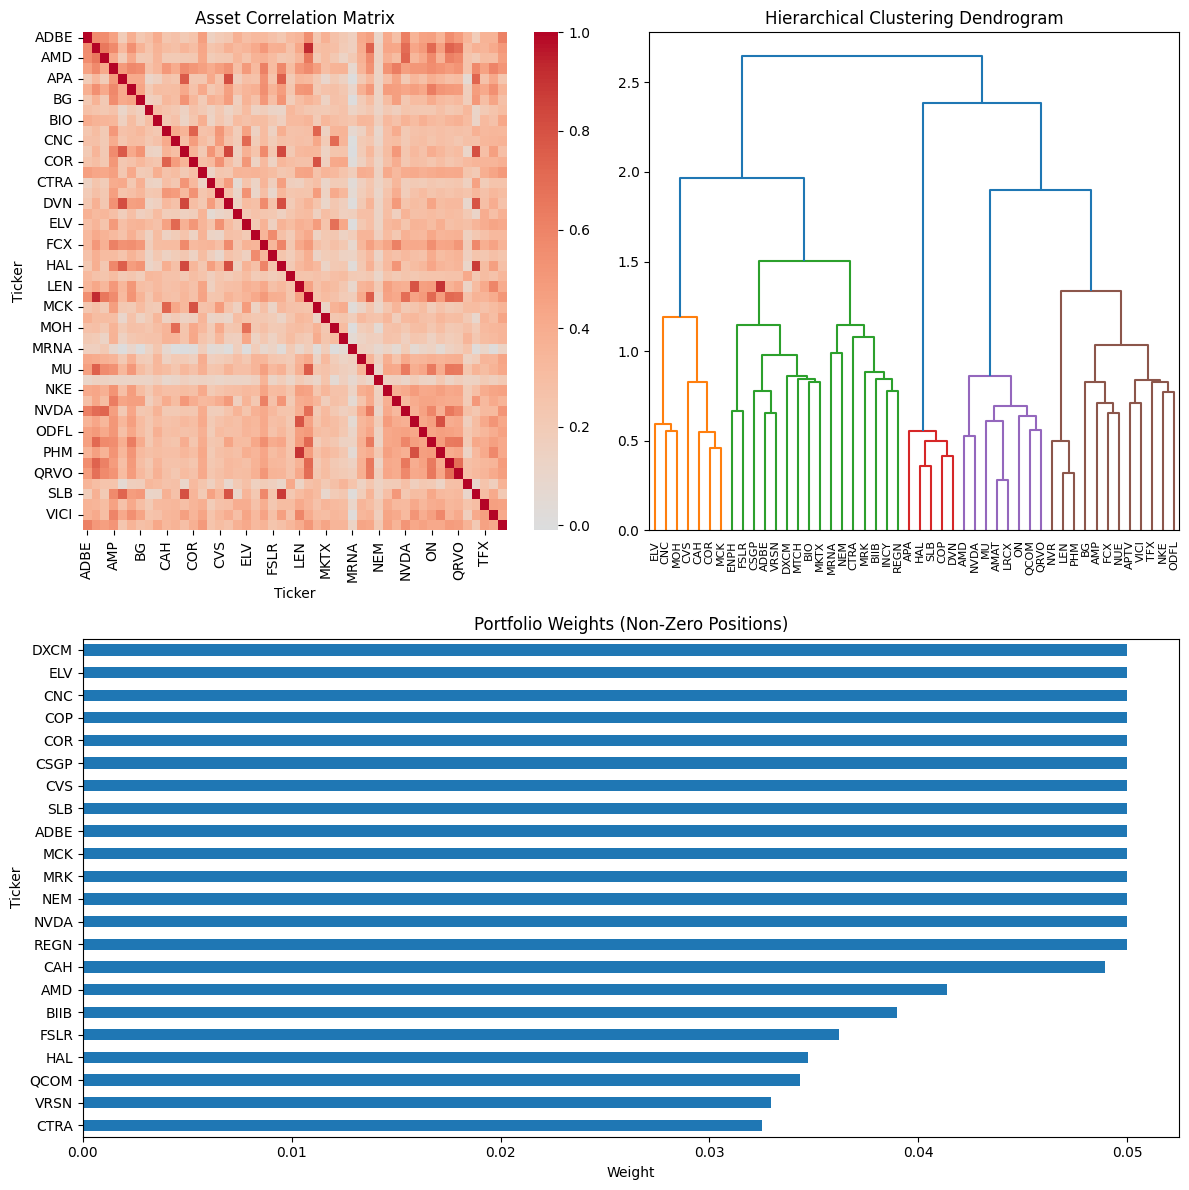

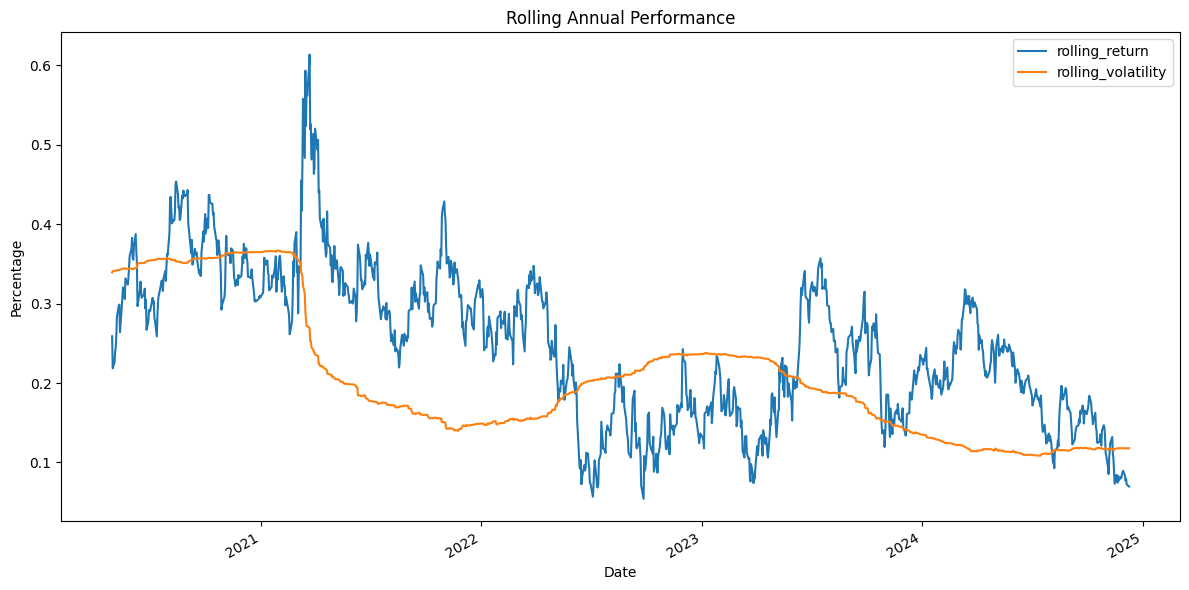

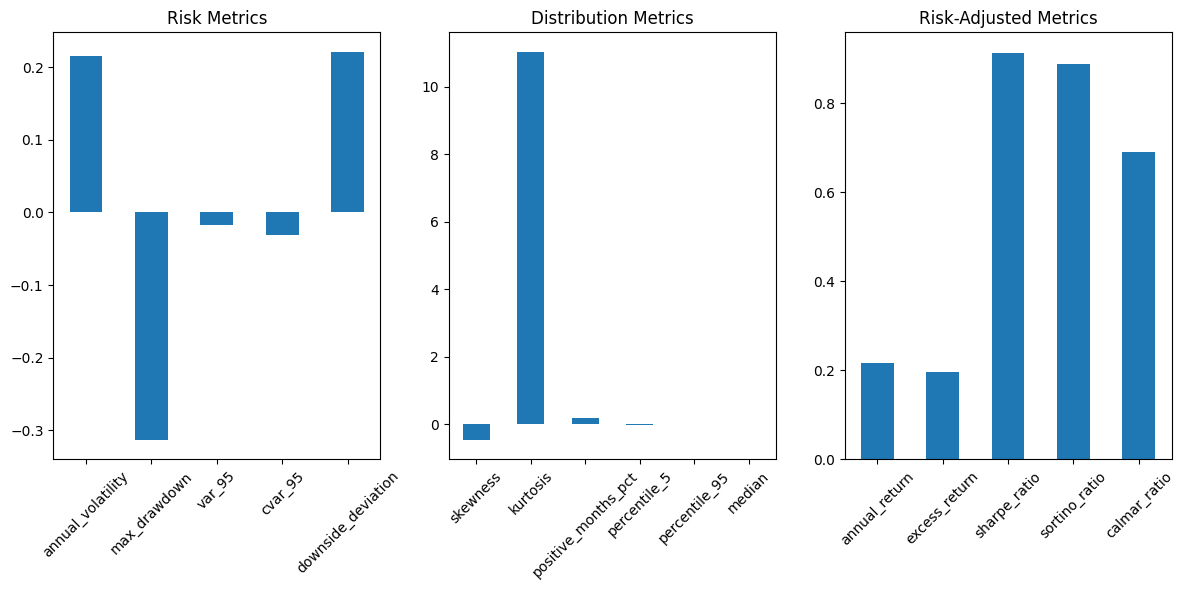

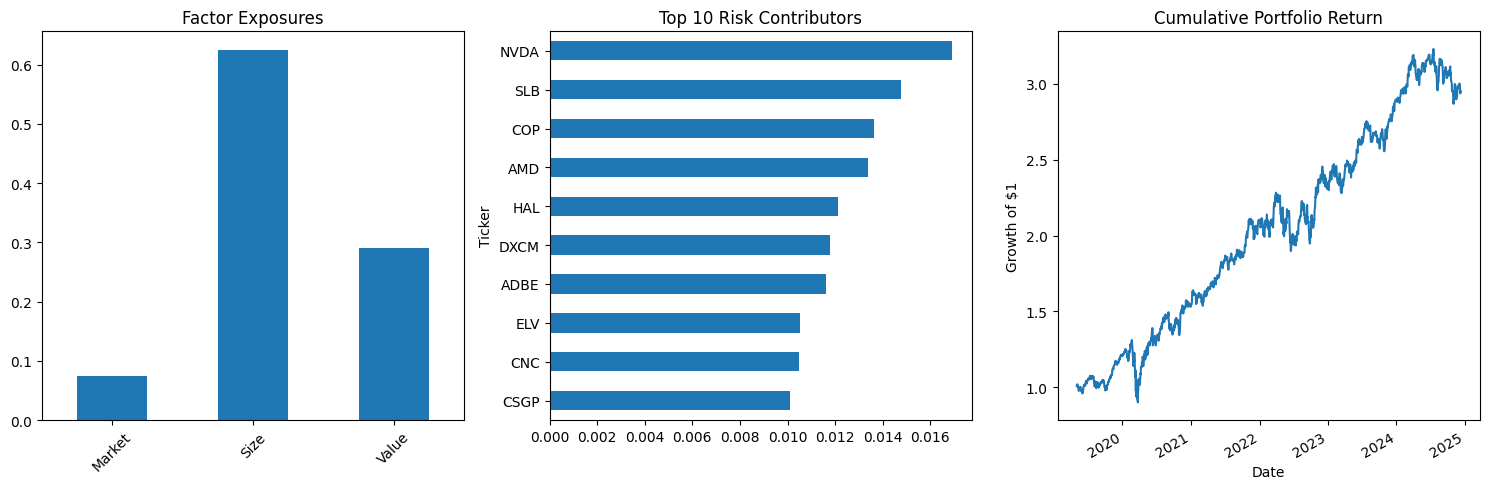


Portfolio Risk Metrics:
annual_volatility: 0.2149
max_drawdown: -0.3133
var_95: -0.0176
cvar_95: -0.0311
downside_deviation: 0.2213

Risk-Adjusted Metrics:
annual_return: 0.2163
excess_return: 0.1963
sharpe_ratio: 0.9135
sortino_ratio: 0.8872
calmar_ratio: 0.6905

Factor Exposures:
Market: 0.074
Size: 0.625
Value: 0.290

Top Portfolio Positions:
        Weight  Cluster  Risk_Contribution   Market_Cap
Ticker                                                 
ADBE      0.05        1           0.011619  208932.1260
COP       0.05        2           0.013637  130533.3524
ELV       0.05        1           0.010541   87757.2740
DXCM      0.05        1           0.011775   30829.6941
MCK       0.05        1           0.008741   73535.1288
CVS       0.05        1           0.008204   62391.8510
MRK       0.05        1           0.005574  256125.6091
CSGP      0.05        1           0.010123   32079.3322
COR       0.05        1           0.008473   44864.1861
CNC       0.05        1           0

In [11]:
if __name__ == "__main__":
    manager = PortfolioManager(risk_free_rate=0.02)
    results, analytics, factor_betas, risk_contribution = manager.run_portfolio_optimization(
        data_path='../data/sp500_data.csv',
        min_market_cap=2000,
        start_date="2019-05-01",
        end_date="2024-12-10"
    )
    
    if results is not None:
        print("\nTop Portfolio Positions:")
        print(results.sort_values('Weight', ascending=False).head(10))